In [6]:
from binance.client import Client
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_binance_config_file = 'binance_api.json'

def load_config():
    with open(_binance_config_file, 'r') as read_file:
        return json.load(read_file)

def create_client():
    cfg = load_config()
    return Client(cfg['API Key'], cfg['Secret Key'])

class Coin():
    def __init__(self, ticker, color):
        self.ticker = ticker
        self.timeserie = {}
        self.correlation = {}
        self.__ignorecols = [6,7,8,9,10,11]
        self.__colnames = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        self.__color = color
        self.__figsize = (20, 5)

    def convert_timestamp(self):
        self.timeserie['Date'] = [datetime.utcfromtimestamp(ts/1000).strftime('%m-%d-%Y') for ts in self.timeserie['Date']]
        self.timeserie.index = pd.to_datetime(self.timeserie['Date'])
        self.timeserie = self.timeserie.loc[:,'Open':]
        return self
        
    def convert_dtypes(self):
        for col in self.timeserie.loc[:,'Open':].columns:
            self.timeserie[col] = pd.to_numeric(self.timeserie[col])
        return self
        
    def parse_timeserie(self, _timeserie):
        self.timeserie = pd.DataFrame(_timeserie).drop(self.__ignorecols, axis=1)
        self.timeserie.columns = self.__colnames
        self.convert_timestamp()
        self.convert_dtypes()
        return self
        
    def get_daily_hist_ohlcv(self, client, start_date):
        _timeserie = client.get_historical_klines(self.ticker, Client.KLINE_INTERVAL_1DAY, start_date)
        self.parse_timeserie( _timeserie)
        return self
     
    def scale(self, df):
        return (df - df.min()) * 1.0 / (df.max() - df.min())

    def get_correlation(self, coins):
        df = pd.DataFrame()
        df[self.ticker] = self.timeserie['Close']
        for coin in coins:
            df[coin.ticker] = coin.timeserie['Close']
            
        self.correlation = df.corr()
        
    def plot_correlation(self):
        f, ax = plt.subplots(figsize=(10, 10))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(self.correlation, cmap=cmap, vmax=1, center=0, annot=True,
                    square=True, linewidths=.5, cbar_kws={"shrink": .7})
        plt.title('Coins Correlation', fontsize=20)
        plt.show()
    
    def plot_timeserie(self):
        ax = self.timeserie['Close'].plot(figsize=self.__figsize, color=self.__color)
        ax.set_title(self.ticker+' Price Series', fontsize=20)
        plt.show()
        
    def plot_compare(self, coins):
        
        fig, ax = plt.subplots(figsize=self.__figsize)
        ax.plot(self.scale(self.timeserie['Close']), color=self.__color)
        legend = [self.ticker]
        
        for coin in coins:
            legend.append(coin.ticker)
            ax.plot(self.scale(coin.timeserie['Close']), coin.__color)
        ax.set_title('Coin Comparison', fontsize=20)
        legend = ax.legend(legend)
        plt.show()    

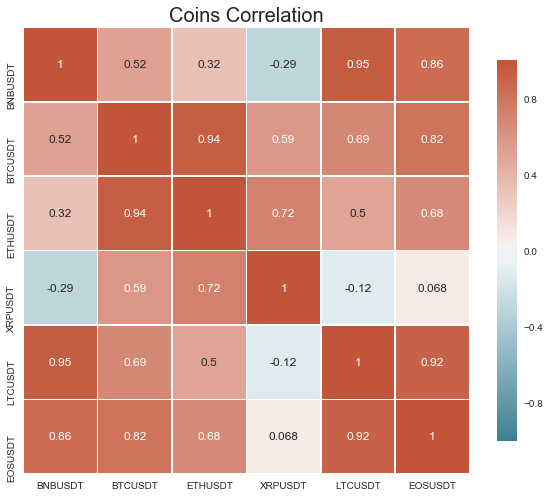

In [7]:
# Create Binance API client
client = create_client()

# Set start date
start_date = '01-01-2019'
    
# Get BNB price series
BNB = Coin('BNBUSDT', 'gold').get_daily_hist_ohlcv(client, start_date)

# Get BTC price series
BTC = Coin('BTCUSDT', 'orange').get_daily_hist_ohlcv(client, start_date)

# Get ETH price series
ETH = Coin('ETHUSDT', 'royalblue').get_daily_hist_ohlcv(client, start_date)

# Get XRP price series
XRP = Coin('XRPUSDT', 'slategrey').get_daily_hist_ohlcv(client, start_date)

# Get LTC price series
LTC = Coin('LTCUSDT', 'deepskyblue').get_daily_hist_ohlcv(client, start_date)

# Get EOS price series
EOS = Coin('EOSUSDT', 'darkcyan').get_daily_hist_ohlcv(client, start_date)

# Correlation
BNB.get_correlation([BTC, ETH, XRP, LTC, EOS])
BNB.plot_correlation()